**Author**: J W Debelius<br/>
**Date**: 10 August 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

#Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Case I T test](#2.-Case-I-T-test)
	* [2.1 Emperical test](#2.1-Emperical-test)
	* [2.2 Extrapolated Power](#2.2-Extrapolated-Power)
	* [2.3 Simulation Paramters](#2.3-Simulation-Paramters)
* [3. Case II T test](#3.-Case-II-T-test)
	* [3.1 Test Parameters](#3.1-Test-Parameters)
	* [3.2 Traditional Power](#3.2-Traditional-Power)
	* [3.3 Simulation Parameters](#3.3-Simulation-Parameters)
	* [3.4 Simple Linear Regression](#3.4-Simple-Linear-Regression)
* [4. Pearson's R](#4.-Pearson's-R)
	* [4.1 Effect Size](#4.1-Effect-Size)
	* [4.2 Emperical Test](#4.2-Emperical-Test)
	* [4.3 Simulation](#4.3-Simulation)
* [5. Build simulations](#5.-Build-simulations)


# 1. Introduction

Traditional definitions for power have been discussed extensively in a variety of sources, include [[1](#lui2014), [2](guenther1977)]. Let us briefly summarize these definitions assuming we have  $k$ populations, $\{P_{1}, P_{2}, ..., P_{k} \}$ where the $i$th population is characterized by some parameter, $\chi_{i}$. We have drawn $k$ samples consisting of $N_{1}, N_{2}, ... N_{k}$ observations, where the $i$th sample is characterized by some parameter, $X_{i}$ such that $\chi_{i} \approx X_{i}$. 

We can use a statistical test, $\textbf{F}$ to test the alternative hypotheses:
$\begin{matrix}
\textbf{H}_{0} & \chi_{1} = \chi_{2} = ... = \chi_{k} & \\
\textbf{H}_{1} & \chi_{i} \neq \chi_{j\neq i} & \forall \{i \epsilon \mathbb{N}, 1 \leq i \leq k\}\\
\end{matrix} \tag{1}$

When the null hypothesis, $\textbf{H}_{0}$ is true, $a$ is drawn from an $A$ distribution, characterized by some set of parameters, $c$. 
If the alternative hypothesis is true, $\Delta_{ij} \neq 0$, where $\Delta_{ij} = \chi_{i} - \chi_{j}$, $i \neq j$ for at least one value of $\Delta_{ij}$. This offset changes at least one of the parameters in $c$, to create a new set of parameters, $c'$. The parameter which changes when $\textbf{H}_{1}$ is true is $\lambda$. So, we now draw the test statistic, $a$ from the $A'$ distribution, characterized by $c'$, which includes $\lambda$. 

This means that the probability of committing a type II error, $\beta$ is
$\beta = P \left [A' < a_{1 - \alpha/2} \right ]\tag{2}$
where $a_{1 - \alpha/2}$ is the two-tailed critical value. 

Since statistical power is defined as $PWR = 1 - \beta$, we can say that 
$\begin{align*}
PWR &= 1 - \beta\\
&= 1 - P \left [A' < a_{1 - \alpha/2} \right ]\\
& = P \left [A' \geq a_{1 - \alpha/2} \right ]\\
\end{align*}\tag{3}$

This notebook will compare traditional power implementations, relying on the implementation of power provided by equation (2), with a Monte Carlo simulation of power to determine the relationship between the two implementations. The Monte Carlo simulation has been defined [elsewhere](http://nbviewer.ipython.org/github/biocore/American-Gut/blob/master/ipynb/Power.ipynb).

We'll use the simulated power to extrapolate power using statsmodel's power module. This can be useful to extrapolate power (when the calculated effect size falls into certain bounds), extending power curves beyond the number of samples that can be drawn for a given distribution.

In [3]:
from __future__ import division

import numpy as np
import americangut.power_plots as pp

from statsmodels.stats.power import FTestAnovaPower

ft = FTestAnovaPower()

def extrapolate_f(counts, empr_pwr, alpha):
    """..."""
    # Gets the average emperical effect size
    pwr_, cnts = empr_pwr
    eff_mean, eff_bound =  pp.collate_effect_size([cnts], [pwr_], alpha)
    # Calculates the extrapolated power curve
    extr_pwr = np.array([
            ft.solve_power(eff_mean, nobs=c, alpha=0.05, power=None)
            for c in counts
        ])
    return extr_pwr

We'll examine five common, simple statistical models where the power equation has been defined and employed. The emperical power implementations are based on the version described in [ref].

We will examine statistical power for three tests dealing with normal distributions:

* Case I t test
* Case II (independent) t test
* Pearson's R

As a result, we'll need to be able to define the summary properties of a normal distribution:

In [4]:
def get_vitals(sample):
    """Returns a summary of the sample"""
    return sample.mean(), sample.std()

Perform 100 simulations of statistical power, comparing the power between 5 and 50 counts, with 5 observation intervals between. We'll set the critical value at 0.05.

In [5]:
num_rounds = 100
counts = np.arange(5, 55, 5)
alpha = 0.05
distributions = {}

# 2. Case I T test

A case I t-test, or an indepdent sample t-test determines if an observation is drawn from a sample.

The test statistic for the case I t test is given as
$t = \frac{(\bar{x} - x)\sqrt{n}}{s} \tag{3}$
where $\bar{x}$ is the mean of the population, $x$ is the value being compared to the sample, and $s$ is the standard devation of the sample. The probability distribution follows a T distribution with $n-1$ degrees of freedom, where $n$ is the number of observations in the sample.

The effect size for a t test is
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&=\frac{1}{\sqrt{n}}\left(\frac{(\bar{x} - x)\sqrt{n}}{s}\right )\\
&=\frac{(\bar{x} - x)}{s}
\end{align*}\tag{4}$
or, we can say that
$t(n) = \lambda\sqrt{n} \tag{5}$

## 2.1 Emperical test

For the emperical test, we will use the `scipy.stats.ttest_1samp` function, which returns a p value. But, for the traditional power calculation, we need to be able to calculate $t(n)$, so we'll seperate the function.

In [6]:
def emp_ttest_1(sample, x0):
    return scipy.stats.ttest_1samp(sample, x0)[1]

## 2.2 Extrapolated Power

We're going to also calculate power by extrapolating from the emperical results. By combining equation (2) and equation (5), we can say that 
$\begin{align*}
1 - \beta &= P(
\end{align*}\tag{6}$

In [7]:
import scipy.stats

def calc_ttest_1(sample, x0, n, alpha=0.05):
    # Calculates the effect size
    [x, s] = get_vitals(sample)
    eff = np.absolute(x - x0)/s
    
    # Calculates the power
    power = np.array([
            scipy.stats.t.cdf(-scipy.stats.t.ppf(1-alpha/2, c-1) + eff*np.sqrt(c), c-1)
            for c in n
        ])
    
    return power

## 2.3 Simulation Paramters

We'll test the set of hypotheses,

<center>**H**<sub>0</sub>: $\bar{x} = 0$<br>
**H**<sub>1</sub>: $\bar{x} \neq 1$</center>

where $\bar{x}$ is the mean of a sample drawn from a population 

In [8]:
def ttest_1_simulate(mu_lim, sigma_lim, count_lims):
    # Gets the distribution parameters
    mu = np.random.randint(*mu_lim)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    # Draws a sample that fits the parameters
    return (mu, sigma, n), [mu + np.random.randn(n) * sigma]

In [9]:
distributions['ttest_1'] = {'emp_test_fun': emp_ttest_1,
                           'trad_test_fun': calc_ttest_1,
                           'sim_function': ttest_1_simulate,
                           'sim_parameters': [[2, 10], [5, 15], [60, 100]],
                           'other_sim_parameters': {},
                           'test_parameters': {'x0': 0},
                           'emp_parameters': {}
                            }

# 3. Case II T test

The case II t test is a test for two independent samples, to determine if the samples are drawn from different distributions.

<center>**H<sub>0</sub>** : $\bar{x}_{1} = \bar{x}_{2}$<br>
**H<sub>1</sub>** : $\bar{x}_{1} \neq \bar{x}_{2}$</center>

There are several ways to calculate this t statistic, but we will operate on the assumption that the two populations have different variances, giving the most extensibe calculation of the test statistic. So,

$\begin{align*}
t &= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}} + \frac{s_{2}^{2}}{n_{2}}}}\\
&= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{n_{2}s_{1}^{2} + n_{1}s_{2}^{2}}{n_{1}n_{2}}}}
\end{align*}\tag{}$

The t statistic follows a T distribution with $df$ degrees of freedom, where $df$ is given as
$df = \frac{(s_{1}^{2}/n_{1} + s_{2}^{2}/n_{2})^{2}}{(s_{1}^{2}/n_{1})^2/(n_{1}-1) + s_{2}^{2}/n_{2})^2/(n_{2}-1)} \tag{}$

For the sake of simplicity, we'll assume that $n_{1} = n_{2}$, which allows us to redefine equation (2.1) as
$t = \frac{\sqrt{n}(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \tag{}$
which means the test statitic is now drawn from a t distribution with df degrees of freedom, where
df is defined as
$df = \left (n-1 \right ) \left (\frac{\left (s_{1}^{2} + s_{2}^{2}  \right )^{2}}{\left (s_{1}^{2} \right)^{2} + \left (s_{2}^{2}  \right )^{2}} \right ) \tag{}$

In [10]:
def get_t_df(n, s1, s2):
    """doc string!"""
    mod = (np.square(np.square(s1) + np.square(s2)) / (np.power(s1, 4) + np.power(s2, 4)))
    return (n-1)*modifier

## 3.1 Test Parameters

For the emperical test, we can use the `scipy.stats.ttest_ind1` function, which will return a p value. We will, once again, need to calculate the test statistic as a function the number of samples.

In [11]:
def emp_ttest_ind(sample1, sample2):
    return scipy.stats.ttest_ind(sample1, sample2)[1]

## 3.2 Traditional Power

In [12]:
def calc_ttest_ind(sample1, sample2, n):
    # Gets the distribuation characterization
    [x1, s1] = get_vitals(sample1)
    [x2, s2] = get_vitals(sample2)
    
    # Gets the effect size
    eff = np.absolute(x1 - x2)/np.sqrt(np.square(s1) + np.square(s2))
    
    # Gets the degree of freedom modifier
    mod = (np.square(np.square(s1) + np.square(s2)) / (np.power(s1, 4) + np.power(s2, 4)))
    
    # Calculates the power
    power = np.array([
            scipy.stats.t.cdf(-scipy.stats.t.ppf(1-alpha/2, mod*(c-1))
                                 + np.sqrt(c)*eff, mod*(c-1))
            for c in n
        ])

    return power

## 3.3 Simulation Parameters

We'll simulate

In [13]:
def ttest_ind_simulate(mu_lim, sigma_lim, counts_lims):
    """..."""
    # Gets the distribution paramters
    mu1, mu2 = np.random.randint(*mu_lim, size=2)
    sigma1, sigma2 = np.random.randint(*sigma_lim, size=2)
    n = np.random.randint(*counts_lims)
    
    # Returns a pair of distributions
    samples =  [mu1 + np.random.randn(n) * sigma1, mu2 + np.random.randn(n) * sigma2]
    return (mu1, mu2, sigma1, sigma2, n), samples

In [14]:
distributions['ttest_ind'] = {'emp_parameters': {},
                              'emp_test_fun': emp_ttest_ind,
                              'other_sim_parameters': {},
                              'sim_function': ttest_ind_simulate,
                              'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                              'test_parameters': {},
                              'trad_test_fun': calc_ttest_ind,                              
                              }

# 4. Pearson's R

We test to see if pearson's correlation coeffecient is not 0.

## 4.1 Effect Size

The test statstic follows a t distribution 
$t = \frac{r_{xy}\sqrt{n-2}}{\sqrt{1 - r_{xy}^{2}}} \tag{}$
where $r_{xy}$ is the pearson correlation coeffecient between the two distribtuions, and $n$ is the number of samples in the two groups.

In [15]:
def calc_pearson(sample1, sample2, n=[5], alpha=0.05):
    r = scipy.stats.pearsonr(sample1, sample2)[0]
    eff = (r)/np.sqrt(1-np.square(r))

    power = np.array([
                scipy.stats.t.cdf(-scipy.stats.t.ppf(1-alpha/2, c-2) + eff*np.sqrt(c-2), c-2)
            for c in n])
    
    return power

## 4.2 Emperical Test

Scipy's `scipy.stats.pearsonr` can calculate the correlation coeffecient *and* a p value for the coeffecient. However, the notes suggest that the p value may not be accurate for smaller sample sizes, so we're going to try an initial test, and compare the dervived p-value, based on [1] with the scipy p-value.

In [16]:
def emp_pearson(*samples):
    return scipy.stats.pearsonr(*samples)[1]

## 4.3 Simulation

For the simulation, we can use the same distributions that were generated in `regress_simulate`.

In [17]:
def regress_simulate(mu_lim, sigma_lim, count_lims, b_lims):
    # Calculates the distribution for the residuals
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    # Calculates the parameters for the line
    m = np.random.randint(*mu_lim)
    b = np.random.randint(*b_lims)
    
    x = np.arange(-n, n, 2)
    y = m*x + b + np.random.randn(n)*sigma
    
    return (sigma, n, m, b), [x, y]

In [18]:
distributions['pearson'] = {'emp_parameters': {'draw_mode': 'matched'},
                            'emp_test_fun': emp_pearson,
                            'other_sim_parameters':{'b_lims':[-2, 2]},
                            'sim_function': regress_simulate,
                            'sim_parameters': [[1, 5], [10, 100], [60, 100]],
                            'test_parameters': {},
                            'trad_test_fun': calc_pearson,
                          }

# 5. Build simulations

In [19]:
import pandas as pd

from skbio.stats.power import subsample_power

for k, params in distributions.iteritems():
    print k
    params['pop_params'] = []
    params['trad'] = []
    params['empr'] = []
    params['extr'] = []
    for i in xrange(num_rounds):
        # Calculates the samples
        pop_params, samples = params['sim_function'](*params['sim_parameters'], **params['other_sim_parameters'])
        # Calculates the traditional power
        trad_power = params['trad_test_fun'](*samples, n=counts, **params['test_parameters'])
        #  Calculates the emperical power
        empr_power, empr_counts = subsample_power(lambda x: params['emp_test_fun'](*x, **params['test_parameters']),
                                                  samples,
                                                  min_counts=5,
                                                  max_counts=55,
                                                  counts_interval=5,
                                                  num_runs=3,
                                                  num_iter=100,
                                                  **params['emp_parameters'])
        extr_power = np.squeeze(extrapolate_f(counts, [empr_power, empr_counts], alpha))
        # Updates the information
        params['pop_params'].append(pop_params)
        params['trad'].append(trad_power)
        params['empr'].append(empr_power.mean(0))
        params['extr'].append(extr_power)

dists = pd.DataFrame.from_dict(distributions, orient='index')

pearson
ttest_ind
ttest_1


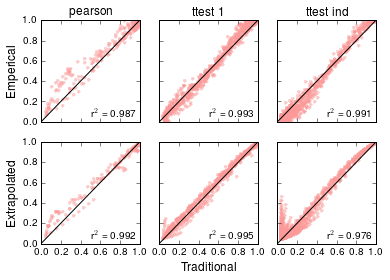

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax1 = fig.add_subplot(2, 3, idx+1)
    ax2 = fig.add_subplot(2, 3, idx+4)
    ax1.plot(np.hstack(dists.loc[name, 'trad']),
            np.hstack(dists.loc[name, 'empr']),
            '.', color='#fb9a99', alpha=0.5)
    ax2.plot(np.hstack(dists.loc[name, 'trad']),
            np.hstack(dists.loc[name, 'extr']),
            '.', color='#fb9a99', alpha=0.5)
    
    ax1.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax2.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_title(name.replace('_', ' '))
    
    if idx == 0:
        ax1.set_yticklabels(ax1.get_yticks())
        ax1.set_ylabel('Emperical', size=12)
        ax2.set_yticklabels(ax2.get_yticks())
        ax2.set_ylabel('Extrapolated', size=12)
    else:
        ax1.set_yticklabels('')
        ax2.set_yticklabels('')
    ax1.set_xticklabels('')
    ax2.set_xticklabels(ax2.get_xticks())
    if idx == 1:
        ax2.set_xlabel('Traditional', size=12)
    
    r21, p1 = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad']),
                                   np.hstack(dists.loc[name, 'empr']))
    r22, p2 = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad'])[np.isnan(np.hstack(dists.loc[name, 'extr']))==False],
                                   np.hstack(dists.loc[name, 'extr'])[np.isnan(np.hstack(dists.loc[name, 'extr']))==False])
    ax1.text(0.95, 0.05, 'r$^2$ = %1.3f' % r21, ha='right')
    ax2.text(0.95, 0.05, 'r$^2$ = %1.3f' % r22, ha='right')

# fig = ax.figure
# # fig.savefig('/Users/jwdebelius/Desktop/model_check.pdf')

In [22]:
help(scipy.stats.linregress)

Help on function linregress in module scipy.stats.stats:

linregress(x, y=None)
    Calculate a regression line
    
    This computes a least-squares regression for two sets of measurements.
    
    Parameters
    ----------
    x, y : array_like
        two sets of measurements.  Both arrays should have the same length.
        If only x is given (and y=None), then it must be a two-dimensional
        array where one dimension has length 2.  The two sets of measurements
        are then found by splitting the array along the length-2 dimension.
    
    Returns
    -------
    slope : float
        slope of the regression line
    intercept : float
        intercept of the regression line
    r-value : float
        correlation coefficient
    p-value : float
        two-sided p-value for a hypothesis test whose null hypothesis is
        that the slope is zero.
    stderr : float
        Standard error of the estimate
    
    
    Examples
    --------
    >>> from scipy import st

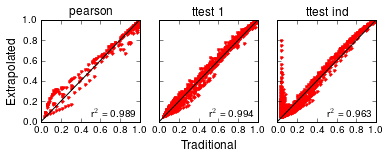

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'trad']),
            np.hstack(dists.loc[name, 'extr']),
            'r.')
    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(name.replace('_', ' '))
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False],
                                 np.hstack(dists.loc[name, 'extr'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False])
    
    ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Extrapolated', size=12)
axb.set_xlabel('Traditional', size=12)

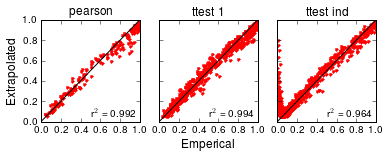

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'empr']),
            np.hstack(dists.loc[name, 'extr']),
            'r.')
    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(name.replace('_', ' '))
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'empr'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False],
                                 np.hstack(dists.loc[name, 'extr'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False])
    ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Extrapolated', size=12)
axb.set_xlabel('Emperical', size=12)

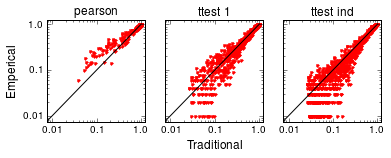

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'trad']),
            np.hstack(dists.loc[name, 'empr']),
            'r.')
    ax.plot(np.power(10., np.arange(-3, 1, 1)), np.power(10., np.arange(-3, 1, 1)), 'k-')
    ax.set_xlim(0.0075, 1.25)
    ax.set_ylim(0.0075, 1.25)
    ax.set_title(name.replace('_', ' '))
    ax.semilogx()
    ax.semilogy()
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad']),
                                 np.hstack(dists.loc[name, 'empr']))
#     ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Emperical', size=12)
axb.set_xlabel('Traditional', size=12)

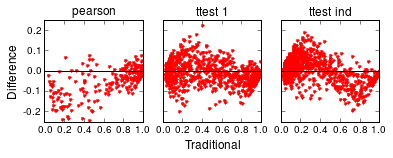

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'trad']),
            np.hstack(dists.loc[name, 'trad']) - np.hstack(dists.loc[name, 'empr']),
            'r.')
    ax.plot(np.arange(0, 1.1, 0.1), 0*np.arange(0, 1.1, 0.1), 'k-')
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.25, 0.25])
    ax.set_title(name.replace('_', ' '))
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad']),
                                 np.hstack(dists.loc[name, 'empr']))
#     ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Difference', size=12)
axb.set_xlabel('Traditional', size=12)

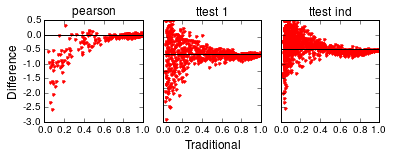

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'trad']),
            (np.hstack(dists.loc[name, 'trad']) - np.hstack(dists.loc[name, 'empr']))/np.hstack(dists.loc[name, 'trad']),
            'r.')
    ax.plot(np.arange(0, 1.1, 0.1), 0*np.arange(0, 1.1, 0.1), 'k-')
    ax.set_xlim([0, 1])
#     ax.set_ylim([-0.25, 0.25])
    ax.set_title(name.replace('_', ' '))
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad']),
                                 np.hstack(dists.loc[name, 'empr']))
#     ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Difference', size=12)
axb.set_xlabel('Traditional', size=12)

* <a id="lui2014"></a>Lui, X.S. (2014) *[Statistical power analysis for the social and behavioral sciences: basic and advanced techniques](http://roger.ucsd.edu/search~S9?/Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D/Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D&SUBKEY=statistical+power/1%2C861%2C861%2CE/frameset&FF=Xstatistical%20power&=&Da=&Db=&searchscope=9&p=&SORT=D&1%2C1%2C)*. New York: Routledge. 378 pg.
* <a id="guenther1977"></a>Guenther, W.C. (1977). "[Power and Sample Size for Approximate Chi-square Tests](https://stat.duke.edu/~zo2/dropbox/pdf/2683047.pdf)". *The American Statistician* **31**:83-85.